In [2]:
using JuMP, Gurobi
using LinearAlgebra
using Distributions, Random, PDMats
using MLJ, Tables
using DataFrames, DataFramesMeta
using JLD, CSV
using PlotlyJS
using Pipe
using LaTeXStrings

Random.seed!(43)

TaskLocalRNG()

In [3]:
using Revise

includet("../models/forward.jl")
import .Forward as Forward

includet("../models/inversedemand.jl")
import .InverseDemand as IODemand

includet("../models/inverselinreg.jl")
import .InverseLinReg as IOLinReg

includet("../datagen/data-generation.jl")
import .DataGeneration as DataGen

In [4]:
LinearW = @MLJ.load LinearRegressor pkg = "GLM"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


import MLJGLMInterface ✔

MLJGLMInterface.LinearRegressor

In [5]:
Random.seed!(42)

TaskLocalRNG()

In [6]:
u_1 = 20
n_points = 100

function generate_data!(n_points=100, u_1=20)
    u_2 = u_3 = 1000

    dist_phi = Uniform(-5, 5)
    phis_1 = rand(dist_phi, n_points)
    phis_2 = rand(dist_phi, n_points)

    intercept_1 = 16
    intercept_2 = 30

    slope_1 = 0.5
    slope_2 = 4

    std_dev = 1
    noises_1 = rand(Normal(0, std_dev^2), n_points)
    noises_2 = rand(Normal(0, std_dev^2), n_points)

    demands_1 = intercept_1 .+ slope_1 .* phis_1 .+ noises_1
    demands_2 = intercept_2 .+ slope_2 .* phis_2 .+ noises_2

    df_1 = DataFrame(:intercept_1 => fill(1.0, n_points), :intercept_2 => fill(0.0, n_points), :phi => phis_1, :demand => demands_1)
    df_2 = DataFrame(:intercept_1 => fill(0.0, n_points), :intercept_2 => fill(1.0, n_points), :phi => phis_2, :demand => demands_2)

    return vcat(df_1, df_2), phis_1, phis_2, demands_1, demands_2
end

df, phis_1, phis_2, demands_1, demands_2 = generate_data!()
df_test, _, _, _, _ = generate_data!()
first(df, 5)

Row,intercept_1,intercept_2,phi,demand
,Float64,Float64,Float64,Float64
1,1.0,0.0,-3.26425,14.4161
2,1.0,0.0,-1.78338,15.8161
3,1.0,0.0,-2.41415,14.5696
4,1.0,0.0,-3.33561,15.3738
5,1.0,0.0,0.27015,15.8026


In [7]:
y, X = unpack(df, ==(:demand), colname -> true);

In [74]:
l_model = LinearW(fit_intercept=false)
l_mach = machine(l_model, X, y) 

fit!(l_mach);
l_model_int1, l_model_int2, l_model_slope = fitted_params(l_mach).coef

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492


3-element Vector{Float64}:
 15.902747440928863
 29.690752922597046
  2.148058773027491

In [75]:
max_phi, min_phi = extrema(df.phi)
x_cap = [min_phi, max_phi]
y_cap = fill(u_1, length(x_cap));

y_l_model_com1 = l_model_int1 .+ l_model_slope .* x_cap
y_l_model_com2 = l_model_int2 .+ l_model_slope .* x_cap

2-element Vector{Float64}:
 40.404417732778406
 18.965823148889143

In [76]:
com1_weight = 5.0
weights = vcat(fill(com1_weight, n_points), fill(1.0, n_points))

w_model = LinearW(fit_intercept=false)
w_mach = machine(w_model, X, y, weights) 

fit!(w_mach);
w_model_int1, w_model_int2, w_model_slope = fitted_params(w_mach).coef

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492


3-element Vector{Float64}:
 16.02255731431805
 29.44768403420401
  1.0208891986374589

In [77]:
y_w_model_com1 = w_model_int1 .+ w_model_slope .* x_cap
y_w_model_com2 = w_model_int2 .+ w_model_slope .* x_cap

2-element Vector{Float64}:
 34.539474268193295
 24.350539999037725

In [78]:
p1 = plot([
    scatter(x=phis_1, y=demands_1, name="Commodity 1", mode="markers", line=attr(color="blue")), 
    scatter(x=phis_2, y=demands_2, name="Commodity 2", mode="markers", line=attr(color="orange")),
    scatter(x=x_cap, y=y_cap, name="Max capacity of arc AB", mode="lines", line=attr(color="red", dash="dot")),
    scatter(x=x_cap, y=y_l_model_com1, name="Predicted commodity 1", mode="lines", line=attr(color="blue")),
    scatter(x=x_cap, y=y_l_model_com2, name="Predicted commodity 2", mode="lines", line=attr(color="orange")),

    ],
    Layout(
        xaxis_title="Contextual information", 
        yaxis_title="Demand",
        showlegend=false,
        title="Unweighted observations"),
);

In [79]:
p2 = plot([
    scatter(x=phis_1, y=demands_1, name="Commodity 1", mode="markers", line=attr(color="blue"), showlegend=false), 
    scatter(x=phis_2, y=demands_2, name="Commodity 2", mode="markers", line=attr(color="orange"), showlegend=false),
    scatter(x=x_cap, y=y_cap, name="Max capacity of arc AB", mode="lines", line=attr(color="red", dash="dot"), showlegend=false),
    scatter(x=x_cap, y=y_w_model_com1, name="Predicted commodity 1", mode="lines", line=attr(color="blue"), showlegend=false),
    scatter(x=x_cap, y=y_w_model_com2, name="Predicted commodity 2", mode="lines", line=attr(color="orange"), showlegend=false),

    ],
    Layout(
        xaxis_title="Contextual information", 
        yaxis_title="Demand",
        title="Weighted observations (w1=5.0, w2=1.0)")
);


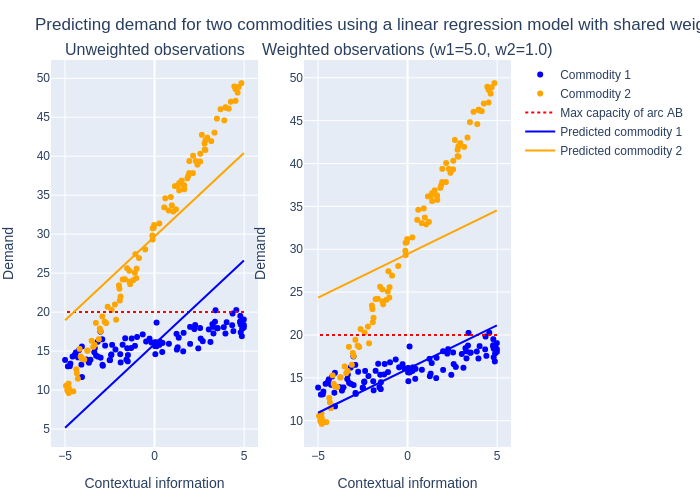

In [80]:
p = [p1 p2]
relayout!(p, title_text="Predicting demand for two commodities using a linear regression model with shared weights")
p

In [81]:
l_pred = Matrix(X) * fitted_params(l_mach).coef
w_pred = Matrix(X) * fitted_params(w_mach).coef

println("Unweighted RMSE: $(rms(l_pred, y))")
println("Weighted RMSE:   $(rms(w_pred, y))")

Unweighted RMSE: 5.475173246134605
Weighted RMSE:   6.457925676416305


In [82]:
function total_task_loss(pred, cap=u_1, arc_cost=1, n_points=n_points)
    com1_pred = pred[1:n_points]

    n = length(pred)
    n_above_cap = length(filter(p -> p > u_1, com1_pred))
    n_below_cap = n - n_above_cap

    return  arc_cost * (2 * n_above_cap + n_below_cap) / n
end

println("Unweighted optimization cost: $(total_task_loss(l_pred))")
println("Weighted optimization cost:   $(total_task_loss(w_pred))")


Unweighted optimization cost: 1.175
Weighted optimization cost:   1.085


In [83]:
y_test, X_test = unpack(df_test, ==(:demand), colname -> true);

In [84]:
function regret(pred, ys, cap=u_1, arc_cost=1, n_points=n_points)
    com1_pred = pred[1:n_points]
    com1_ys = ys[1:n_points]

    com1_regret = map(zip(com1_pred, com1_ys)) do (pred, y)
        if pred > cap && y > cap
            return 0
        elseif pred > cap && y <= cap
            return 1 
        elseif pred <= cap && y > cap
            return 10 * (y - cap)
        else
            return 0
        end 
    end

    return vcat(com1_regret, fill(0, n_points))
end

function weight_update(weights, regret)
    proportional_regret = regret ./ length(regret)

    return weights + weights .* proportional_regret
end

weight_update (generic function with 1 method)

In [135]:
weights = fill(1, 2*n_points)
n_iter = 1200

train_regrets = []
test_regrets = []
mach_weights = []
obs_weights = []
test_preds = []
train_preds = []
mach = nothing

for i in 1:n_iter
    model = LinearW(fit_intercept=false)
    mach = machine(model, X, y, weights) 
    
    fit!(mach, verbosity=0);
    
    pred = Matrix(X) * fitted_params(mach).coef
    test_pred = Matrix(X_test) * fitted_params(mach).coef

    push!(train_regrets, regret(pred, y))
    push!(test_regrets, regret(test_pred, y_test))
    push!(mach_weights, fitted_params(mach).coef)
    push!(obs_weights, weights)
    push!(train_preds, pred)
    push!(test_preds, test_pred)

    weights = weight_update(weights, last(train_regrets))
end

In [136]:
sum.(train_regrets)'

1×1200 adjoint(::Vector{Real}) with eltype Real:
 33  33  33  33  33  33  33  33  33  33  …  98  84.6382  87.6382  25  83.0492

In [137]:
sum.(test_regrets)'

1×1200 adjoint(::Vector{Real}) with eltype Real:
 29  29  29  29  29  29  29  28  28  …  18.217  83  99  89  95  19.217  83

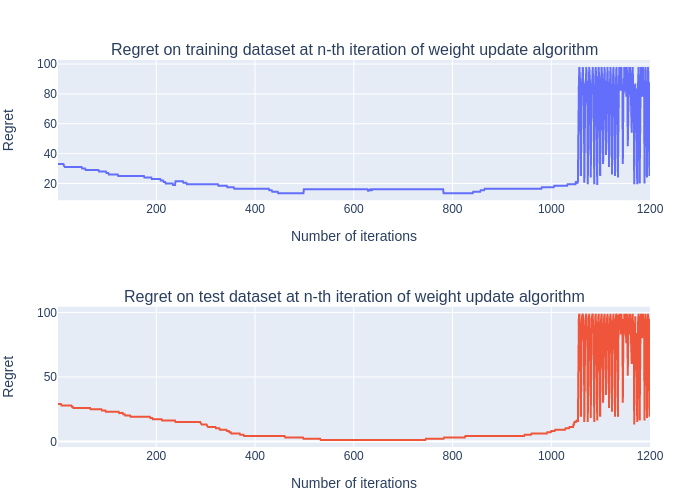

In [138]:
p1 = plot(x=1:n_iter, sum.(train_regrets), name="Training regret", Layout(xaxis_title="Number of iterations", yaxis_title="Regret", title="Regret on training dataset at n-th iteration of weight update algorithm"))
p2 = plot(x=1:n_iter, sum.(test_regrets), name="Test regret", Layout(xaxis_title="Number of iterations", yaxis_title="Regret", title="Regret on test dataset at n-th iteration of weight update algorithm"))

p = [p1; p2]
relayout!(p, showlegend=false)
p

In [95]:
filter(s -> s.>20, y_test[1:100])

1-element Vector{Float64}:
 20.021704404280108

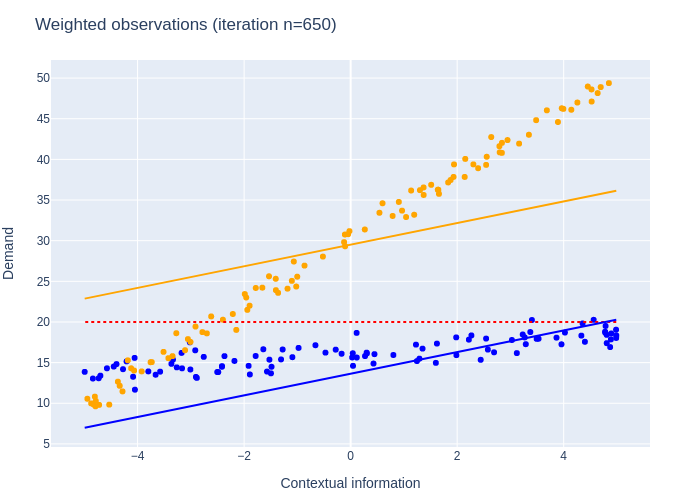

In [139]:
iter_index = 650
model_int1, model_int2, model_slope = mach_weights[iter_index]
y_model_com1 = model_int1 .+ model_slope .* x_cap
y_model_com2 = model_int2 .+ model_slope .* x_cap

data = [
    scatter(x=phis_1, y=demands_1, name="Commodity 1", mode="markers", line=attr(color="blue"), showlegend=false), 
    scatter(x=phis_2, y=demands_2, name="Commodity 2", mode="markers", line=attr(color="orange"), showlegend=false),
    scatter(x=x_cap, y=y_cap, name="Max capacity of arc AB", mode="lines", line=attr(color="red", dash="dot"), showlegend=false),
    scatter(x=x_cap, y=y_model_com1, name="Predicted commodity 1", mode="lines", line=attr(color="blue"), showlegend=false),
    scatter(x=x_cap, y=y_model_com2, name="Predicted commodity 2", mode="lines", line=attr(color="orange"), showlegend=false),
]

layout = Layout(
    xaxis_title="Contextual information", 
    yaxis_title="Demand",
    title="Weighted observations (iteration n=$iter_index)")

weights_plot = plot(data, layout)

In [140]:
weighted_obs = filter(w -> last(w) > 1, collect(zip(1:length(train_preds[iter_index]), train_preds[iter_index], y, X.phi, obs_weights[iter_index])))

for obs in weighted_obs
    println(obs)
end

(8, 17.674458192763243, 17.782106723778043, 3.0276255127997302, 2.393650878025824)
(9, 20.042960422484747, 18.417530088453226, 4.807576556964708, 25.45505735807218)
(18, 20.014762257089302, 19.508738712811663, 4.786385378290976, 25.45505735807218)
(19, 20.15678514467119, 18.58551508077652, 4.89311687462418, 25.45505735807218)
(22, 18.134504540536458, 18.764028201787944, 3.3733545422292295, 3.1966301348728368)
(24, 17.797623428292372, 16.171629654001013, 3.1201853114918663, 2.579596231060989)
(25, 18.912968824162313, 17.252479396128987, 3.958377556815078, 5.532981046024051)
(29, 17.94467332957729, 18.462575734776234, 3.230694654507019, 2.8218949695570372)
(32, 19.440483642177277, 19.814540236952432, 4.354809757450431, 8.711055933111632)
(33, 18.788585215719422, 18.069302107797125, 3.8649021397575396, 5.057898046111897)
(41, 18.34042574335722, 17.93907470446673, 3.5281062056969965, 3.675717436327887)
(43, 20.276575470123753, 19.049265833350223, 4.983140397589247, 25.45505735807218)
(46, 

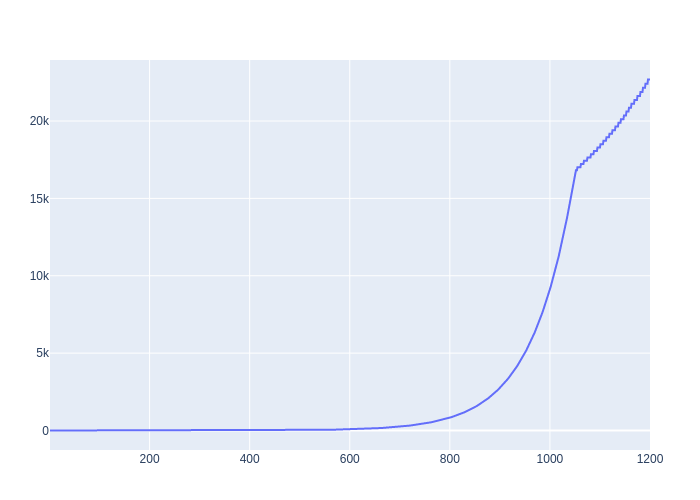

In [146]:
plot(x=1:n_iter, map(x -> x[76], obs_weights))

In [151]:
weight_update(fill(1, 200), regret(train_preds[650], y))[76]

1.0120546250043956

In [152]:
println(train_regrets[650][76])

2.410925000879125


In [153]:
regret(train_preds[650], y)[76]

2.410925000879125